https://www.transtats.bts.gov/Fields.asp?Table_ID=236

In [1]:
from __future__ import division #, print_function # Imports from __future__ since we're running Python 2

In [2]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
random_state = 0
%matplotlib inline
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
from sklearn.ensemble import IsolationForest
from helpers.feature_engineering import dateStrToDayYear, getMappingOfSimilarCategoricalColumns, \
    compareSimilarCategoricalColumns 
from helpers.my_one_hot_encoder import MyOneHotEncoder
from helpers.py_helpers import is_number
from scipy.stats import skew, kurtosis
from helpers.outliers import MyOutliers
from sklearn.preprocessing import StandardScaler
from helpers.plot_helper import scatter_2d_label, renderPointsWithDecisionBounds
from sklearn.decomposition import PCA # Import the PCA module
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
from sklearn.manifold import MDS
from sklearn.dummy import DummyClassifier
from sklearn.manifold import Isomap
from helpers.performance_issues import subsample_keeping_class_proportions, rbfPCAkernel
from flights_delay.feature_processing import FlightDelayFeatureProcessing
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from matplotlib.colors import ListedColormap
from flights_delay.flight_delay_scoring import printFlightDelayScores, getFlightDelayScores
from helpers.my_cross_validation import MyCrossValidation
from sklearn.metrics import log_loss
from helpers.performance_issues import processSeparately
from helpers.plot_helper import scatter_2d_label
from flights_delay.flight_delay_scoring import getScore_onKFold_callback, scoreWithDimReduction
from flights_delay.dataset import getRbfKernelPCADimReducedDataset
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
from time import time, sleep

In [4]:
rng = np.random.RandomState(seed=random_state)
#n_jobs = 3 #we prefer to have it run in only a few cores instead of all of them to avoid making the system unstable
n_jobs = 1  #due to memory restrictions

# Flying to New York City - Classifiers Optimization

In [5]:
target_col = 'IS_DELAYED'

In [6]:
path_data = os.path.realpath(os.path.join(os.getcwd(), '../Data',
                                          'binary_train_data_numerical_no_outliers_normalized.csv'))
assert os.path.isfile(path_data)
path_data

'/home/student/pligor.george@gmail.com/msc_Artificial_Intelligence/dme_Data_Mining/dmedatarats/Data/binary_train_data_numerical_no_outliers_normalized.csv'

In [7]:
df = pd.read_csv(path_data, header=0)
df.shape

(180133, 533)

In [8]:
df.sample(5, random_state=random_state)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_NUM,DEP_TIME,DEP_DELAY,DEP_DELAY_GROUP,DISTANCE,DISTANCE_GROUP,...,DEP_TIME_BLK_9,DEP_TIME_BLK_10,DEP_TIME_BLK_11,DEP_TIME_BLK_12,DEP_TIME_BLK_13,DEP_TIME_BLK_14,DEP_TIME_BLK_15,DEP_TIME_BLK_16,DEP_TIME_BLK_17,IS_DELAYED
165999,0.468116,0.157033,1.162862,-0.966237,0.826288,-1.706637,-0.573752,-0.367736,-1.102857,-0.977812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
118690,-0.441352,-0.731585,-1.453911,1.574641,-0.126675,-1.473074,-0.293951,-0.367736,-0.415552,-0.253819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
170863,-1.350820,-1.323998,-0.885047,-1.474413,-0.466086,-0.556195,-0.675497,-0.742084,0.051700,0.108177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
95968,-1.350820,-1.027791,0.935317,0.050114,1.192461,-1.469214,-0.497442,-0.367736,0.468941,0.470173,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
121221,-0.441352,-0.731585,-0.771274,1.066466,-0.928208,1.611501,-0.726370,-0.742084,-1.124291,-0.977812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False


In [9]:
df.info()  #here we are verifying that everything is numerical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180133 entries, 0 to 180132
Columns: 533 entries, QUARTER to IS_DELAYED
dtypes: bool(1), float64(532)
memory usage: 731.3 MB


In [10]:
XX = df.drop(labels=[target_col], axis=1)
yy = df[target_col]
XX.shape, yy.shape

((180133, 532), (180133,))

In [11]:
del df  #maybe saves memory

In [12]:
columns_not_one_hot = np.array([col for col in XX.columns if not is_number(col[-1])])
columns_not_one_hot

array(['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_NUM',
       'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_GROUP', 'DISTANCE',
       'DISTANCE_GROUP', 'YDAY'], 
      dtype='|S15')

In [13]:
XX[columns_not_one_hot].describe()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_NUM,DEP_TIME,DEP_DELAY,DEP_DELAY_GROUP,DISTANCE,DISTANCE_GROUP,YDAY
count,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05
mean,-1.484052e-12,3.126480e-13,1.822616e-13,5.892627e-13,-2.010778e-14,-2.247057e-15,8.564950e-15,-2.171187e-13,1.507782e-13,5.062069e-13,-1.497683e-14
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-1.350820e+00,-1.620204e+00,-1.681456e+00,-1.474413e+00,-1.080291e+00,-2.708448e+00,-1.362280e+00,-1.116432e+00,-1.370063e+00,-1.339808e+00,-1.748677e+00
25%,-4.413519e-01,-7.315854e-01,-8.850472e-01,-9.662371e-01,-7.820001e-01,-8.611779e-01,-6.754973e-01,-7.420838e-01,-7.270543e-01,-6.158155e-01,-8.703420e-01
50%,-4.413519e-01,-1.391733e-01,2.513468e-02,5.011427e-02,-2.526487e-01,6.535273e-02,-4.974424e-01,-3.677355e-01,-1.469179e-01,-2.538192e-01,-1.659459e-03
75%,4.681160e-01,7.494450e-01,8.215438e-01,5.582900e-01,3.341416e-01,8.278103e-01,3.673956e-01,3.809610e-01,4.689412e-01,4.701733e-01,8.380670e-01
max,1.377584e+00,1.638063e+00,1.731726e+00,1.574641e+00,3.774599e+00,1.922275e+00,4.004803e+00,4.124444e+00,2.190775e+00,2.280155e+00,1.774314e+00


### Dummy Classifier

In [14]:
dc = DummyClassifier(random_state=random_state).fit(XX, yy)

In [15]:
dc.score(XX, yy)

0.50231218044444936

In [16]:
dummy_preds = dc.predict(XX)

In [17]:
printFlightDelayScores(y_true=yy, y_pred=dummy_preds)

precision score for delayed flights: 0.485576923077
f1 score for both classes: [ 0.51742959  0.48621698]
f1 score for is_delayed true class: 0.486216975185
f1 score with weighted average: 0.502332107115
f1 score with unweighted average: 0.501823283906


In [18]:
log_loss(y_true = yy, y_pred = dc.predict_proba(XX))

17.18952831409981

## Quadratic Discriminant Classifier

In [19]:
clf = QuadraticDiscriminantAnalysis()

### all features

In [20]:
cv = MyCrossValidation(n_folds=5, random_state=random_state)

In [21]:
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))

/home/student/anaconda2/envs/dme/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [22]:
scores

precision_score             0.576954
f1_score_nondelayed         0.339173
f1_score_delayed            0.665552
f1_score_weighted_avg       0.496747
f1_score_unweighted_avg     0.502363
log_loss                   13.138165
accuracy_score              0.574276
dtype: float64

### Repeat for different dim reductions

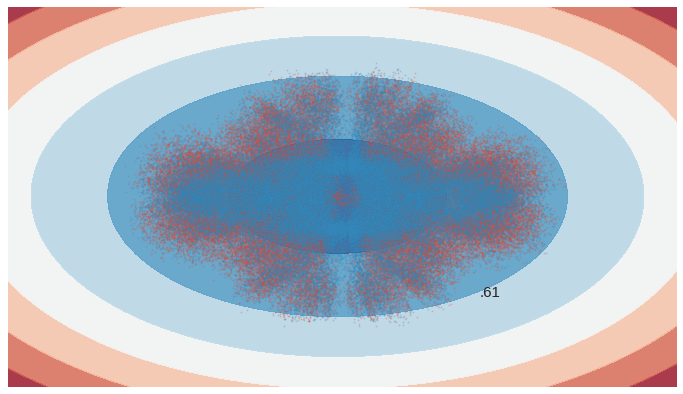

precision_score            0.606079
f1_score_nondelayed        0.636320
f1_score_delayed           0.582139
f1_score_weighted_avg      0.610113
f1_score_unweighted_avg    0.609230
log_loss                   0.675510
accuracy_score             0.611110
dtype: float64

In [36]:
scoreWithDimReduction(n_components=2,
    clf=clf, target_col=target_col, random_state=random_state)

In [37]:
scoreWithDimReduction(n_components=3,
    clf=clf, target_col=target_col, random_state=random_state)

precision_score            0.587356
f1_score_nondelayed        0.621471
f1_score_delayed           0.561441
f1_score_weighted_avg      0.592435
f1_score_unweighted_avg    0.591456
log_loss                   0.667995
accuracy_score             0.593661
dtype: float64

In [38]:
scoreWithDimReduction(n_components=4,
    clf=clf, target_col=target_col, random_state=random_state)

precision_score            0.622680
f1_score_nondelayed        0.656888
f1_score_delayed           0.542861
f1_score_weighted_avg      0.601733
f1_score_unweighted_avg    0.599874
log_loss                   0.659986
accuracy_score             0.608001
dtype: float64

In [39]:
scoreWithDimReduction(n_components=5,
    clf=clf, target_col=target_col, random_state=random_state)

precision_score            0.608900
f1_score_nondelayed        0.637367
f1_score_delayed           0.591203
f1_score_weighted_avg      0.615036
f1_score_unweighted_avg    0.614285
log_loss                   0.653908
accuracy_score             0.615667
dtype: float64

#### Conclusions
Even if there is greater flexibility by having the gaussian decision boundary be an ellipsis instead of a circle there is still not any real improvement from using the QDA classifier instead of the GaussianNB one

### K-neighbors classifier

In [29]:
def plotLowDim(XX_lowdim, yy_lowdim, alpha=0.2, ss=2, lw=2):
    plt.figure(figsize=(12,7))
    scatter_2d_label(XX_lowdim, y=yy_lowdim,
                     alpha=alpha, s=ss, lw=lw)
    plt.title('Labelled data in PCA space with kernel RBF')
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    # Add a legend outside the plot at specified point
    plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
    plt.show()

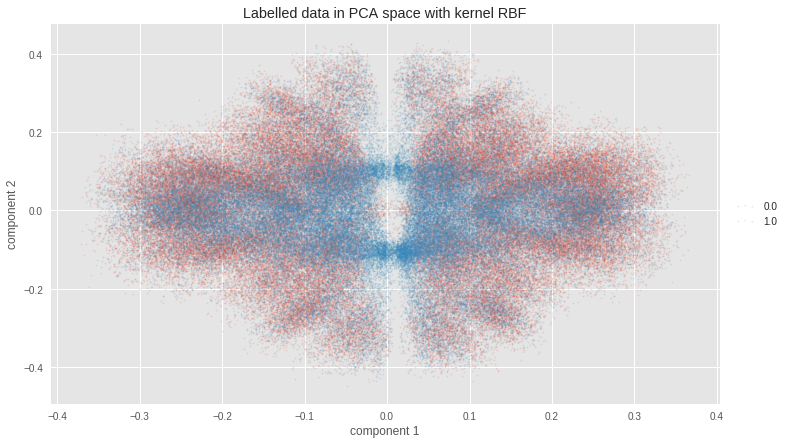

In [31]:
XX_lowdim, yy_lowdim = rbfPCAkernel(
    gamma=1e-1,
    XX=XX, yy=yy, target_column_name=target_col, n_components=2, random_state=random_state, saving=False)
plotLowDim(XX_lowdim=XX_lowdim.values, yy_lowdim=yy_lowdim.values, alpha=0.1, ss=1, lw=1)

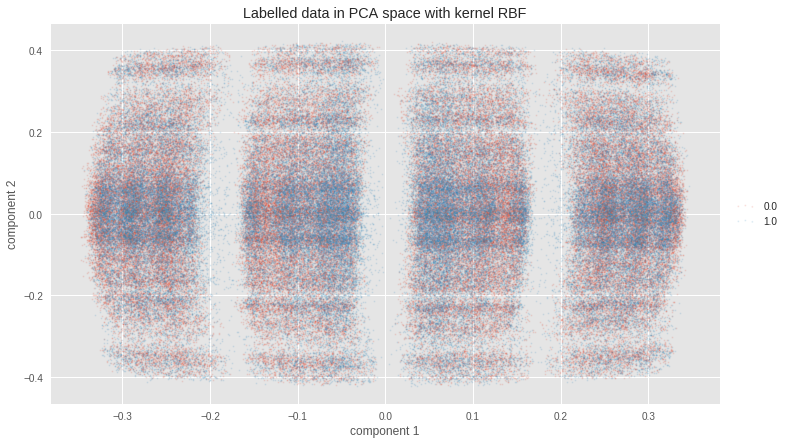

In [33]:
XX_lowdim, yy_lowdim = rbfPCAkernel(
    gamma=1e-2,
    XX=XX, yy=yy, target_column_name=target_col, n_components=2, random_state=random_state, saving=False)
plotLowDim(XX_lowdim=XX_lowdim.values, yy_lowdim=yy_lowdim.values, alpha=0.1, ss=1, lw=1)

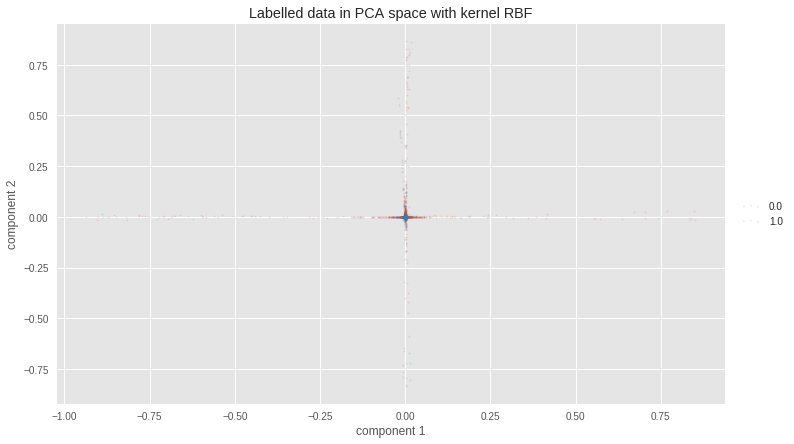

In [34]:
XX_lowdim, yy_lowdim = rbfPCAkernel(
    gamma=1e0,
    XX=XX, yy=yy, target_column_name=target_col, n_components=2, random_state=random_state, saving=False)
plotLowDim(XX_lowdim=XX_lowdim.values, yy_lowdim=yy_lowdim.values, alpha=0.1, ss=1, lw=1)

In [19]:
def gpOptimization(n_jobs=-1):  # using all the features is too slow with any kind of neighbor
    
    def objective(params): # Here we define the metric we want to minimise
        (n_neighbors, ) = params
        print "current neighbors: {}".format(n_neighbors)
        start = time()

        clf = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=n_jobs)

        cv = MyCrossValidation(n_folds=5, random_state=random_state)

        scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
        score = scores['accuracy_score']
        print "current accuracy score: {}".format(score)
        print "time elapsed: {}".format(time() - start)
        print

        # We want to maximise accuracy score, i.e. minimise minus average accuracy
        return -score
    
    neighborsSpace = Integer(1, 10)
    space  = [neighborsSpace]
    
    return gp_minimize(
        func=objective, # function that we wish to minimise
        dimensions=space, #the search space for the hyper-parameters
        #x0=x0, #inital values for the hyper-parameters
        n_calls=25, #number of times the function will be evaluated
        random_state=random_state, #random seed
        n_random_starts=5,  #before we start modelling the optimised function with a GP Regression
                            #model, we want to try a few random choices for the hyper-parameters.
        kappa=1.9, #trade-off between exploration vs. exploitation.
        n_jobs=n_jobs
    )

Above IMPOSSIBLE to execute with given computational resources

In [20]:
def gpOptimizationLowDim(n_jobs=-1, verbose=True):
    
    def objective(params): # Here we define the metric we want to minimise
        (n_neighbors, n_components, gamma) = params
        if verbose:
            print "current neighbors: {}".format(n_neighbors)
            print "current components: {}".format(n_components)
            print "current gamma: {}".format(gamma)
        
        start = time()
        
        XX_lowdim, yy_lowdim = rbfPCAkernel(XX=XX, yy=yy, target_column_name=target_col, n_components=n_components,
                     random_state=random_state, gamma=gamma)

        clf = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=n_jobs)

        cv = MyCrossValidation(n_folds=5, random_state=random_state)

        scores = cv.onEachKFold(XX_lowdim, yy_lowdim, getScore_onKFold_callback(clf))
        score = scores['accuracy_score']
        
        if verbose:
            print "current accuracy score: {}".format(score)
            print "time elapsed: {}".format(time() - start)
            print

        # We want to maximise accuracy score, i.e. minimise minus average accuracy
        return -score
    
    neighbors_space = Integer(1, 3)
    n_components_space = Integer(2, 5)
    gamma_space = Real(1e-2, 1e0, prior='uniform')  #log-uniform could also be a sensible approach
    
    return gp_minimize(
        func=objective, # function that we wish to minimise
        dimensions=[neighbors_space,
                    n_components_space,
                    gamma_space], #the search space for the hyper-parameters
        #x0=x0, #inital values for the hyper-parameters
        n_calls=25, #number of times the function will be evaluated
        random_state=random_state, #random seed
        n_random_starts=5,  #before we start modelling the optimised function with a GP Regression
                            #model, we want to try a few random choices for the hyper-parameters.
        kappa=1.9, #trade-off between exploration vs. exploitation.
        n_jobs=n_jobs
    )

In [ ]:
res_gp = gpOptimizationLowDim()

current neighbors: 1
current components: 5
current gamma: 0.718037472709
current accuracy score: 0.577245699675
time elapsed: 764.747295141

current neighbors: 2
current components: 5
current gamma: 0.649435171936
current accuracy score: 0.592545536689
time elapsed: 734.223648787

current neighbors: 1
current components: 5
current gamma: 0.892855270774


In [ ]:
fig = plt.figure(figsize=(12,6))
plot_convergence(res_gp)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(res_gp.func_vals)
plt.scatter(range(len(res_gp.func_vals)), res_gp.func_vals)
plt.ylabel(r'$f(x)$')
plt.xlabel('Number of calls $n$')
plt.xlim([0, len(res_gp.func_vals)])
plt.show()